In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import seaborn as sns

## Spaceship Titanic CRISP-DM

This notebook addressses ...

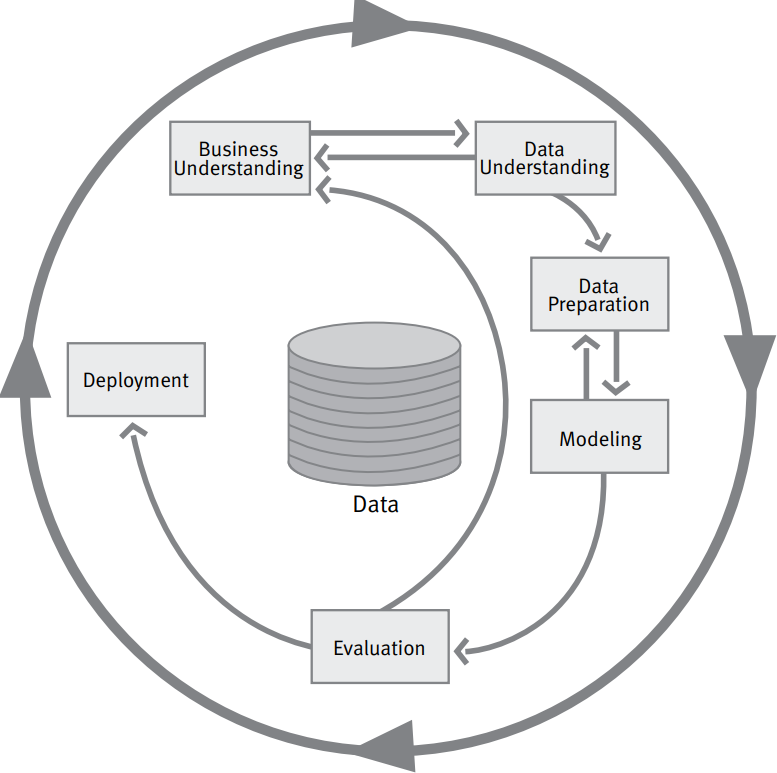

Resources:
- [Quick CRISP-DM explainer](https://www.datascience-pm.com/crisp-dm-2/)
- [Full guide](https://web.archive.org/web/20220401041957/https://www.the-modeling-agency.com/crisp-dm.pdf)


### Business Understanding
Understanding the objectives an requirements of the project
1. Determine business objectives: What does the customer really want?
2. Assess situation: available resources, project requirements, risks & contingencies, and conduct a cost-benefit analysis
3. Determine data mining goals: in addition to defining business objectives, what does success look like from a techincal perspective?
4. Produce project plan: Select technologies and tools and define detailed plans for each project phase

**Spaceship Titanic Scenario**
1. Business objective
    - From Kaggle: *"To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system"*
    - Given the available training data set, predict which passengers were transported
2. Assess situation
    - Resources: more information on the Kaggle page
    - Project requirements: Max 4 hours of time to finish the final prediction (set by myself)
3. Data mining goals: in this case the data mining goal is very similar to business objective
4. Project plan
    1. Describe the data: number of records, feature description, feature dtypes
    2. Create a baseline:
        1. Select few techniques to predict `transported` feature: logitic regression, svm, random forest
        2. Naively prepare the data to create a baseline: dropping NaN entries, no further imputing, scale the data, no new feature engineering
        3. Naively predict using the data and selected models: no futher finetuning of the parameters
    3. Try to improve the model within 4 hours:
        1. Find relationships between the features
        2. Assess data quality, e.g. missing data/invalid data
        3. Prioritize efforts for data imputing, feature selection, feature engineering and select what steps to include
        4. Predict using new data set and explore quick parameter finetuning (gridsearch?)

### Data Understanding
1. Collect data
2. Describe the data: document the surface properties of the data like: feature types, dtypes, number of records
3. Explore the data: dig deeper into the data, visualize relationships
4. Verify the data quality: is there invalid/missing data?

**Spaceship Titanic Scenario**
As written in the process plan above, we're first setting a baseline and therefore only collecting and describing the data. After the baseline is set, we'll move on with further data exploration

- A feature description is available on [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data)
dtypes
- Categorical features: HomePlanet, CryoSleep, Cabin, Destination, VIP, Transported
- Numerical features: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Other features: 
    - PassengerId, potentially a valuable feature as this indicates to what group a passenger belongs to
    - Name, could indicate to which family passenger belongs to

In [2]:
train_df = pd.read_csv('train_spaceship_titanic.csv')

In [3]:
train_df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
print(train_df.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [5]:
print("Dtypes of the features are:")
print(train_df.dtypes)

Dtypes of the features are:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


### Baseline Strategy

- Dropping rows that contain a NaN value
- Dropping `Name`, `Cabin` and `PassengerId` as they need processing to become useful
- Applying one hot encoding to `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`
- Scale the data 

In [6]:
baseline_df = train_df.copy()

# Drop rows that contain missing values
baseline_df.dropna(inplace=True)

# Drop the features that are not required
baseline_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

Xb = baseline_df.drop(['Transported'], axis=1)
yb = baseline_df['Transported']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=2)

Apply scaling to numeric features and one-hot-encoding to categorical features

In [7]:
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
# setting handle_unknown to error, to raise an error in case an unknown class is encountered during tranformation of the data
categorical_transformer = Pipeline(steps = [("encoder", OneHotEncoder(handle_unknown="error"))])

preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)])

Get baseline score using different classification methods. Selecting different methods, so we can later check per method how to improve.
- Logistic regression, selected as linear method
- QuadraticDiscriminantAnalysis: selected as non-linear method; raised a collinear warning
- RandomForestClassifier: selected as three based method, and because of its randomness

In [8]:
names = ["logistic regression",
         "QDA",
         "Random forest"]

classifiers = [LogisticRegression(),
               QuadraticDiscriminantAnalysis(),
               RandomForestClassifier(max_depth=5, random_state=2, n_estimators=50, max_features=2)]

for name, clf in zip(names, classifiers):
    pipe = make_pipeline(preprocessor, clf)
    pipe.fit(Xb_train, yb_train)
    yb_pred = pipe.predict(Xb_test)
    score = accuracy_score(yb_pred, yb_test)
    print(f"Accuracy of {name}: {score}")

Accuracy of logistic regression: 0.79313824419778
Accuracy of QDA: 0.7295660948536832


c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy of Random forest: 0.7573158425832492


### Explore the data

Three potential areas to investigate and improve our model:
- Feature selection (to self: find an example why this is important, why not selecting all?)
- Dealing with missing data
    - Generating dummy values
    - Imputation (different strategies)
- New feature generation
    - Combining multiple features
    - Creating new features from one feature
- Model selection
    - Parameter finetuning

In [9]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


steps
1. Check number of missing values
    - All features contain, more or less, the same proportion of missing values
    - From the heatmap, the missing values seem to be randomly spread across the features
    - Conclusion: No prefrence for a specific feature for missing data handling. Further analysis of the relationships between will indicate where missing data handling is required.
    - We can try to see whether accuracy improves by handling missing values as dummy values for categorical features -> I think the results will be marginal, there doesn't seem to be a relation between missing values accross multiple features
2. Get relationships in the data
    - Let's start with a simple pointplot
3. Automatically assess feature importance
4. ...

- Discuss next steps with Gianluca (should be practical, must fit in 4 hours)
    - New feature generation:
        - luxury and essential expenses
        - From now unusable features
    - Automatic feature selection:
        - backward, forward, mixed selection
    - Improve evaluation method
        - Cross validation
        - ...
    - Grid search to improve models
    - select best model
- Discuss dummy values for missing values
- Check same solution for random forest and QDA -> impossible

### Checking missing values

In [10]:
print("% of missing values per feature:")
100*(train_df.isna().sum()/len(train_df))

% of missing values per feature:


PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

<AxesSubplot: >

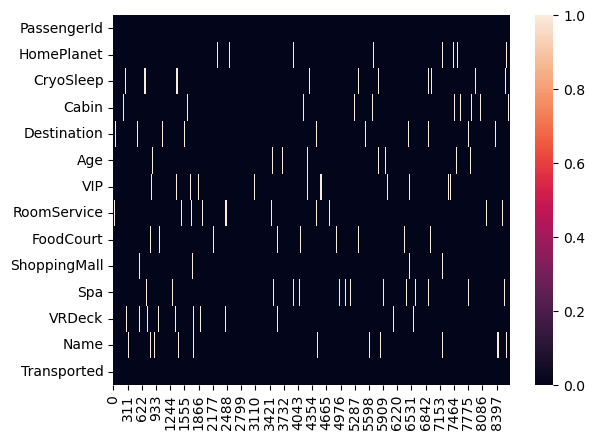

In [11]:
sns.heatmap(train_df.isna().transpose())

In [24]:
missing_dummy_df = train_df.copy()

# Drop the features that are not required
missing_dummy_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

missing_dummy_df = missing_dummy_df.dropna(subset=["VIP", "CryoSleep", "Age", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

X_dummy = missing_dummy_df.drop(['Transported'], axis=1)
y_dummy = missing_dummy_df['Transported']

X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=2)

numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = ['HomePlanet', 'Destination']
# setting handle_unknown to error, to raise an error in case an unknown class is encountered during tranformation of the data
categorical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy='constant', fill_value = "missing")),
    ("encoder", OneHotEncoder(handle_unknown="error"))])

bool_features = ['VIP', 'CryoSleep']
bool_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder(handle_unknown="error"))])

preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                 ("cat", categorical_transformer, categorical_features),
                                                 ("bool", bool_transformer, bool_features)])

names = ["logistic regression",
         "QDA",
         "Random forest"]

classifiers = [LogisticRegression(),
               QuadraticDiscriminantAnalysis(),
               RandomForestClassifier(max_depth=5, random_state=2, n_estimators=50, max_features=2)]

for name, clf in zip(names, classifiers):
    pipe = make_pipeline(preprocessor, clf)
    pipe.fit(X_dummy_train, y_dummy_train)
    y_dummy_pred = pipe.predict(X_dummy_test)
    score = accuracy_score(y_dummy_pred, y_dummy_test)
    print(f"Accuracy of {name}: {score}")

Accuracy of logistic regression: 0.7922794117647058
Accuracy of QDA: 0.7380514705882353


c:\Users\LuukvanRoessel\Anaconda3\envs\ml-luuk\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy of Random forest: 0.7380514705882353


### Visualizing feature relations

Top row pairplot: Rougly, people with more expenses on `ShoppingMall` and `FoodCourt` (more essential expenses), where more likely to be transported. Furthermore, people with more expenses on `RoomService`, `Spa` and `VRDeck` (more luxury costs) are less likely to be transported. Create has `HasEssentialExpenses` and `HasLuxuryExpenses`. 

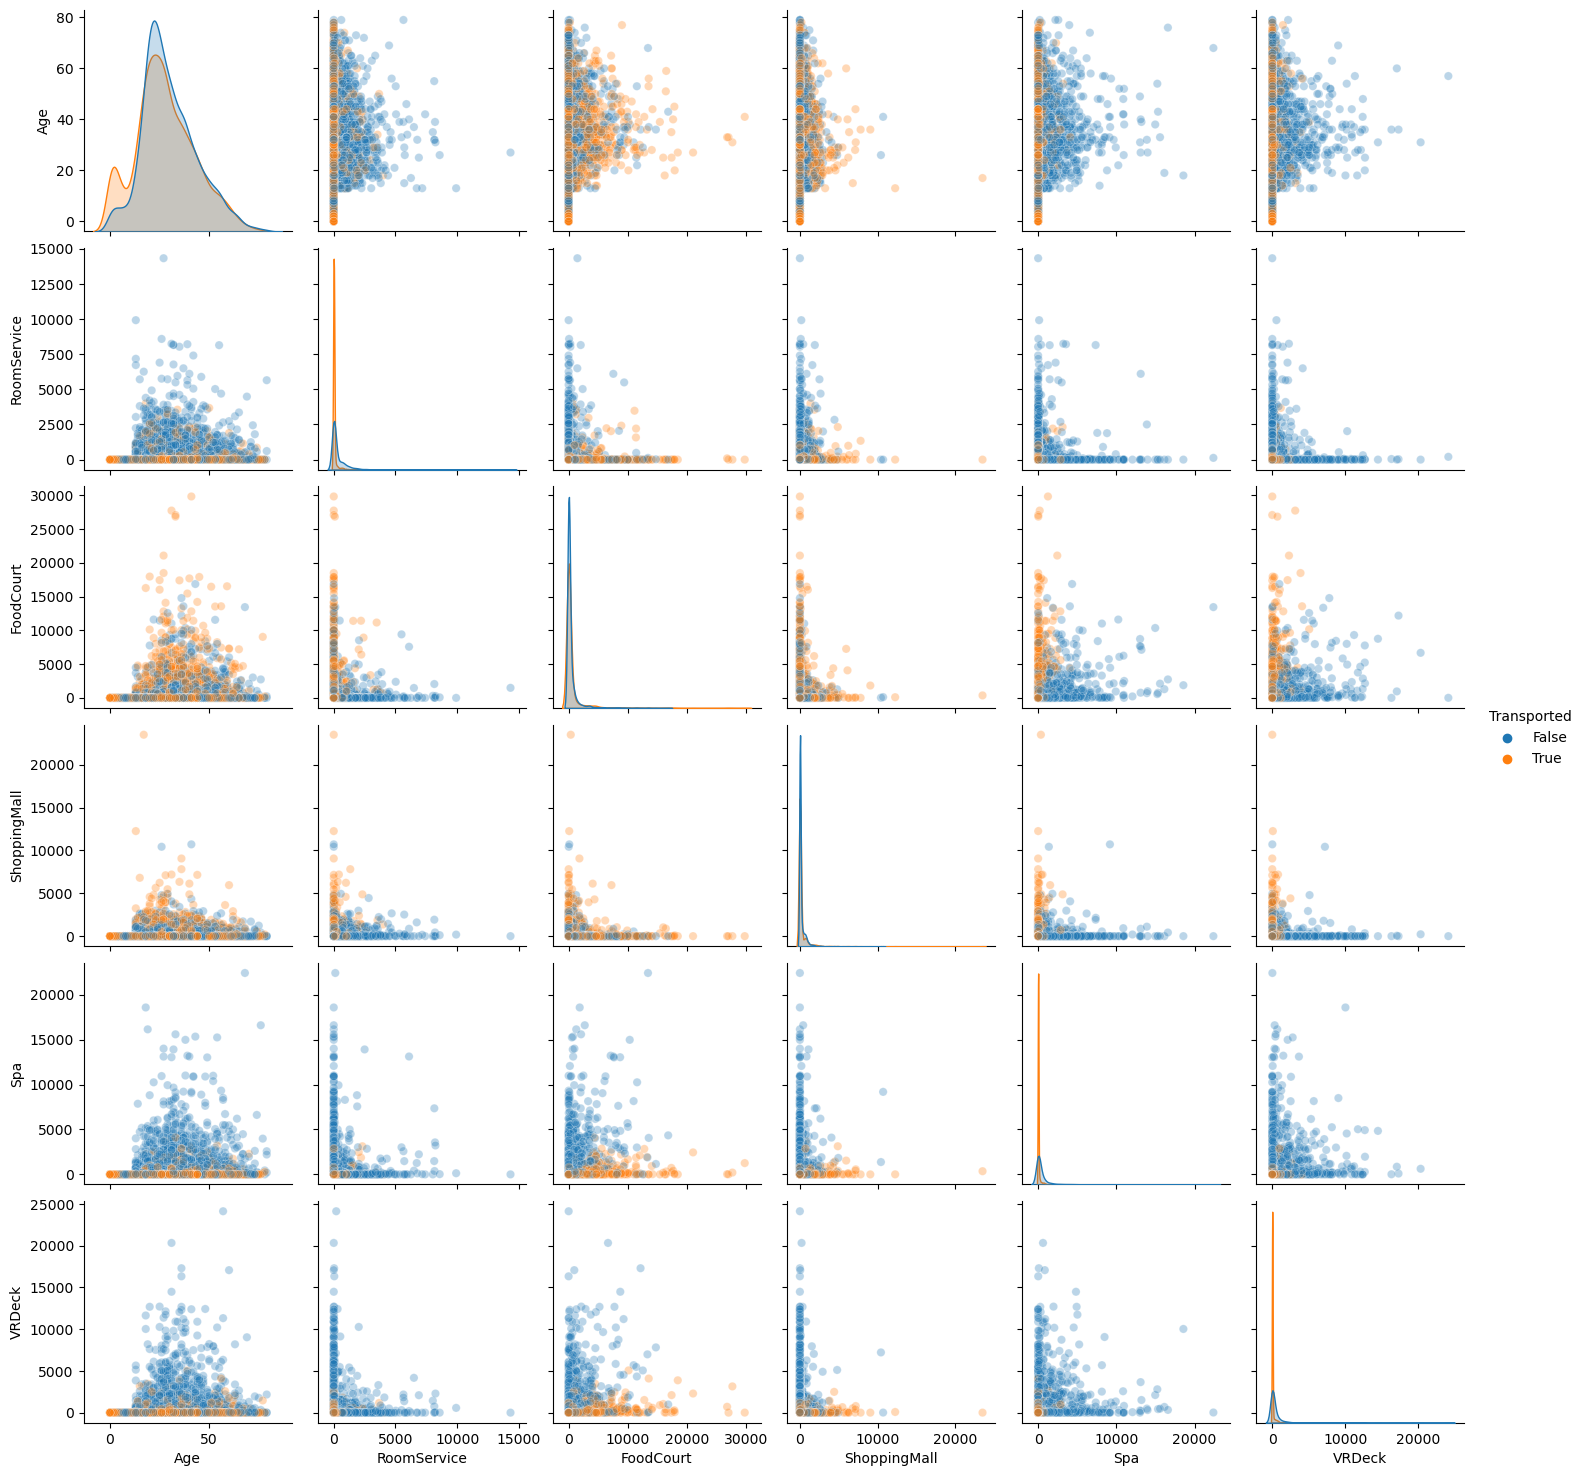

In [13]:
sns.pairplot(train_df.drop(['CryoSleep', 'VIP'], axis=1), hue='Transported', plot_kws = {'alpha':0.3})